In [1]:
import pandas as pd
import numpy as np
import os, sys

#from tf_keras_vis.utils import normalize

import json
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
import seaborn as sns
from tqdm.notebook import tqdm
import pickle
import itertools

pd.set_option('display.max_rows', 300)

In [2]:
def normalize_using_provided_min_max(df_sum, min_val, max_val):
    #normalize based on provided min and max values
    if len(df_sum.shape)>1:
        vals = ((df_sum.iloc[:,3:]-min_val) / (max_val-min_val)).copy()
        normalized = pd.concat([df_sum.iloc[:,:3],vals], axis=1)
    else:
        vals = ((df_sum-min_val) / (max_val-min_val)).copy()
        normalized = vals#pd.concat([df_sum,vals], axis=1)
        
    if normalized.shape != df_sum.shape:
        print("ERROR: number values in does not match number of values out")
    return normalized

def normalize(sal_weather_sum, sal_cons_sum, sal_pcs_sum):
    #normalize across all data
    #find min and max accross all data
    if len(sal_weather_sum.shape)>1:
        all_values = sal_weather_sum.iloc[:,3:].values.flatten().tolist() + sal_cons_sum.iloc[:,3:].values.flatten().tolist() + sal_pcs_sum.iloc[:,3:].values.flatten().tolist()
    else:
        all_values = sal_weather_sum.values.tolist() + sal_cons_sum.values.tolist() + sal_pcs_sum.values.tolist()
    max_val = max(all_values)
    min_val = min(all_values)
    print(max_val, min_val)

    #run normalization
    weath_norm = normalize_using_provided_min_max(sal_weather_sum, min_val, max_val)
    cons_norm = normalize_using_provided_min_max(sal_cons_sum, min_val, max_val)
    pcs_norm = normalize_using_provided_min_max(sal_pcs_sum, min_val, max_val)
    return weath_norm, cons_norm, pcs_norm

In [3]:
def create_plots_summary_all(sal_weather, sal_soil, sal_field, sal_fert, sal_pcs, normalize):
    #sum data across days for weather
    sal_weather2 = sal_weather.sum(axis=1)
    tmp_ind = sal_weather2.index.tolist()
    sal_weather2.index = pd.MultiIndex.from_arrays([["Weather"]*len(tmp_ind), tmp_ind])

    #sum data across soil layers
    sal_soil2 = sal_soil.sum()
    tmp_ind = sal_soil2.index.tolist()
    sal_soil2.index = pd.MultiIndex.from_arrays([["Soil"]*len(tmp_ind), tmp_ind])

    #put all together in one df
    all_factors = pd.concat([sal_weather2, sal_soil2, sal_field.unstack(), sal_fert.unstack(), sal_pcs.unstack()])
    #normalize for figure
    if normalize:
        min_val = all_factors.min()
        max_val = all_factors.max()
        all_factors = normalize_using_provided_min_max(all_factors, min_val, max_val)
    
    fig, ax = plt.subplots(figsize=(30,5))
    ax = all_factors.sort_values().plot.bar()
    plt.savefig("../figures/"+method+"sal_all_factors_norm"+str(normalize)+".pdf")
    plt.show()
    
    all_factors_sum = pd.Series([sal_weather.values.flatten().sum(), sal_soil.values.flatten().sum(), sal_field.sum()[0],
                                sal_fert.sum()[0], sal_pcs.sum()[0]], index=["Weather", "Soil", "Field", "Fertility", "Genetics"])
    #normalize
    if normalize:
        min_val = all_factors_sum.min()
        max_val = all_factors_sum.max()
        all_factors_sum = normalize_using_provided_min_max(all_factors_sum, min_val, max_val)
    
    fig, ax = plt.subplots(figsize=(30,5))
    ax = all_factors_sum.sort_values().plot.bar()
    plt.savefig("../figures/"+method+"sal_all_factors_sum_norm"+str(normalize)+".pdf")
    plt.show()
    
    all_factors.to_csv("../figures/"+method+"all_factors_norm"+str(normalize)+".csv")
    all_factors_sum.to_csv("../figures/"+method+"all_factors_sum_norm"+str(normalize)+".csv")
    
    return all_factors, all_factors_sum

In [4]:
def mean_std_all_factors(all_factors, method):
    #take mean and std for each based on rep first then split.
    #calculate mean and std on per split bases
    splits_mean = all_factors.T.reset_index().drop(columns="rep").pivot_table(index=["split"]).T
    splits_std = all_factors.T.reset_index().drop(columns="rep").pivot_table(index=["split"], aggfunc=np.std).T

    #calculate mean and std across all
    all_mean = splits_mean.mean(axis=1)
    all_mean = pd.DataFrame(all_mean, columns=["mean"])
    all_mean["std"] = splits_mean.std(axis=1)
    all_mean["stdErr"] = all_mean["std"]/np.sqrt(len(all_factors.T.reset_index()["split"].unique()))
    all_mean = all_mean.sort_values(["mean"])

    #save data to file
    all_mean.to_csv("../figures/"+method+"_sal_all_factors.csv")

    #create summary of the larger category impacts
    #sum across lower level categories
    tmp = all_factors.copy()
    tmp.reset_index(inplace=True)
    tmp = tmp.pivot_table(index=["level_0"], aggfunc=np.sum)
    tmp.index.name=""
    tmp = tmp.T.reset_index()

    #average within splits
    cat_split_mean = tmp.pivot_table(index=["split"])
    cat_split_std = tmp.pivot_table(index=["split"], aggfunc=np.std)

    #averge across average splits
    cat_mean = pd.DataFrame(cat_split_mean.mean(), columns=["mean"])
    cat_mean["std"] = cat_split_mean.std()
    cat_mean["stdErr"] = cat_mean["std"]/np.sqrt(len(all_factors.T.reset_index()["split"].unique()))
    cat_mean = cat_mean.sort_values(["mean"])

    #save data to file
    cat_mean.to_csv("../figures/"+method+"_sal_sum_large_categories.csv")
    
    return all_mean, cat_mean, splits_mean, splits_std, cat_split_mean, cat_split_std

In [5]:
def re_formate_and_add_labels(weath_test_sum, cons_test_sum, pcs_test_sum, method):
    
    # Weather
    if len(weath_test_sum)!=0:
        #transpose weather data back to original grid.
        #weather data was previously flatened and needs to be moved back to original shape 
        weather_labels = ["Day of year", "Day Length", "Maximum Temperature", "Minimum Temperature", "Precipitation", "Radiation",
                          "Vapor Pressure", "Cumulative thermal time"]
        sal_weather = pd.DataFrame(weath_test_sum.values.reshape(145,8), columns=weather_labels).T
        #turn columns into days after planting, planting date = 0
        days_aft_planting = [-9,-8,-7,-6,-5,-4,-3,-2,-1]+list(range(0,len(sal_weather.columns)-9))
        sal_weather.columns = days_aft_planting
    else:
        sal_weather=weath_test_sum

    #soil and other concatenated data
    if len(cons_test_sum)!=0:
        soil_labels =  ["awc","caco3","cec7","claytotal","dbovendry","ec","gypsum","ksat","om","ph1to1h2o","sandtotal",
                        "silttotal","slope"]
        #expand soil labels over all three horizons used
        new_labels=[]
        for horizon in ["0cm","15cm","30cm"]:
            #print(horizon)
            new_labels = new_labels+[horizon+"_"+x for x in soil_labels]
        soil_labels = new_labels

        general_labels = ['Year', 'Latitude', 'Longitude', 'Altitude', 'Plant Density'] #general data related to the field/location

        #create average for soils
        if "_NO_SOIL_" in method:
            sal_soil=pd.DataFrame(index=soil_labels)
        else:
            sal_soil = pd.DataFrame(cons_test_sum[:-5].values, index=soil_labels, columns=["Soils"])
            sal_soil.index = sal_soil.index.str.split("_",expand=True)
            sal_soil = sal_soil.unstack()
            sal_soil = sal_soil.droplevel(0, axis=1)

        #create average for gerneral/field data (location specif)
        sal_field = pd.DataFrame(cons_test_sum[-5:].values, index=general_labels, columns=["Field"])
    else:
        sal_soil=cons_test_sum
        sal_field=cons_test_sum
        
    #pcs and G2F fertility data
    if len(pcs_test_sum)!=0:
        sal_pcs = pd.DataFrame(pcs_test_sum[:30].values, index=["PC_"+str(x) for x in list(range(1,31))], columns=["Genetics"])
        #pcs_avg

        fert_labels = ['% Clay', '% Sand', '% Silt', '%Ca Sat', '%H Sat','%K Sat', '%Mg Sat', '%Na Sat',
                                    '1:1 S Salts mmho/cm', '1:1 Soil pH','Calcium ppm Ca', 'Magnesium ppm Mg',
                                    'Mehlich P-III ppm P','Nitrate-N ppm N', 'Organic Matter LOI %', 'Potassium ppm K',
                                    'Sodium ppm Na', 'Sulfate-S ppm S', 'WDRF Buffer pH', 'lbs N/A', 'Total K lbs/acre',
                                    'Total N lbs/acre', 'Total P lbs/acre', 'Irrigation amount (inches)', 'Irrigated']
        if len(pcs_norm) > 30:
            sal_fert = pd.DataFrame(pcs_test_sum[30:].values, index=fert_labels, columns=["Fertility"])
        else:
            sal_fert=pd.DataFrame()
    else:
        sal_pcs=pcs_test_sum
        sal_fert=pcs_test_sum
        
    return sal_weather, sal_soil, sal_field, sal_pcs, sal_fert

In [6]:
def summarize_in_and_across_splits(sal_cons_sum, tset):
    #return empty data series in input is empty
    if len(sal_cons_sum) == 0:
        return pd.Series(), pd.Series(), pd.Series(), pd.Series()

    #get desitred set
    sngl_set = sal_cons_sum[sal_cons_sum["set"]==tset].copy()
    sngl_set.drop(columns=["set","rep"], inplace=True)

    #summarize set within split using desired statistic
    sngl_set_split_sum = sngl_set.pivot_table(index=["split"], aggfunc=np.mean)
    sngl_set_split_std = sngl_set.pivot_table(index=["split"], aggfunc=np.std)
    
    #summarize accross split
    sngl_set_sum_all = sngl_set_split_sum.mean(axis=0)
    sngl_set_sum_all_std = sngl_set_split_sum.std(axis=0)
    return sngl_set_sum_all, sngl_set_sum_all_std, sngl_set_split_sum, sngl_set_split_std

def summarize_in_and_across_reps(sal_cons_sum, tset, aggfunct):
    #get desitred set
    sngl_set = sal_cons_sum[sal_cons_sum["set"]==tset].copy()

    #summarize set within reps using desired statistic
    sngl_set_rep_sum = sngl_set.pivot_table(index=["rep"], aggfunc=aggfunct)

    #summarize accross reps
    sngl_set_sum_all = sngl_set_rep_sum.mean(axis=0)

    return sngl_set_sum_all, sngl_set_rep_sum

In [7]:
def fill_missing_data(sal_weather_sum, idx_info, len_stats, weath_len, fill_value):
    sal_weather_sum=[]
    tmp = pd.DataFrame(fill_value, index=range(0, idx_info.shape[0]), columns=range(0, weath_len-3))
    tmp = pd.concat([idx_info, tmp], axis=1)
    for x in range(0,len_stats):
        sal_weather_sum.append(tmp.copy())
    return sal_weather_sum

def check_fill_missing_data(sal_weather_sum, sal_cons_sum, sal_pcs_sum, fill_value):
    #if data is missing (i.e., run with no weather data) then create a place holder for the data based 
    #on the data that is not missing. Final data shape should look like this (?, 1163) (?, 47) (?, 58)
    weath_len=1163
    cons_len=47
    pcs_len=58
    #first, find one that has data and copy the set,rep, and split info
    if len(sal_weather_sum[0]) !=0:
        idx_info = sal_weather_sum[0][["set","rep","split"]].copy().reset_index(drop=True)
        len_stats = len(sal_weather_sum)
    elif len(sal_cons_sum[0]) !=0:
        idx_info = sal_cons_sum[0][["set","rep","split"]].copy().reset_index(drop=True)
        len_stats = len(sal_cons_sum)
    else:
        idx_info = sal_pcs_sum[0][["set","rep","split"]].copy().reset_index(drop=True)
        len_stats = len(sal_pcs_sum)
    
    #if any are equal to zero then add in NaN or -1 or 0?
    if len(sal_weather_sum[0])==0:
        sal_weather_sum = fill_missing_data(sal_weather_sum, idx_info, len_stats, weath_len, fill_value)
    if len(sal_cons_sum[0])==0:
        sal_cons_sum = fill_missing_data(sal_cons_sum, idx_info, len_stats, cons_len, fill_value)
    if len(sal_pcs_sum[0])==0:
        sal_pcs_sum = fill_missing_data(sal_pcs_sum, idx_info, len_stats, pcs_len, fill_value)
    
    #if any are partial then add to front or back
    if sal_pcs_sum[0].shape[1]==33: #PCs included but not fertility add empty fertility to back
        tmp = pd.DataFrame(fill_value, index=range(0, sal_pcs_sum[0].shape[0]), columns=range(30, pcs_len-3))
        for x in range(0,len(sal_pcs_sum)):
            sal_pcs_sum[x] = pd.concat([sal_pcs_sum[x].reset_index(drop=True),tmp], axis=1)
    
    #this part needs some work to make NO_G function
    #elif sal_pcs_sum[0].shape[1]==28: #PCs not included but fertility is add empty PCs to front
    #    tmp = pd.DataFrame(fill_value, index=range(0, sal_pcs_sum[0].shape[0]), columns=range(0, 30))
    #    for x in range(0,len(sal_pcs_sum)):
    #        sal_pcs_sum[x] = pd.concat([tmp, sal_pcs_sum[x].reset_index(drop=True)], axis=1)
    #        sal_pcs_sum[x].columns = ["set", "rep", "split"] + list(range(0, pcs_len-3))
    return sal_weather_sum, sal_cons_sum, sal_pcs_sum

In [8]:
def plot_individual_weather_factor(sal_weather, sal_weather_std, factor):
    y = sal_weather.loc[factor].values
    x = sal_weather.columns.values
    y_err = sal_weather_std.loc[factor].values
    fig, ax = plt.subplots()
    ax.plot(x,y)
    ax.fill_between(x, y - y_err, y + y_err, alpha=0.2)
    ax.set_title(factor)
    ax.set_xlabel("Days After Planting")
    ax.set_ylabel("Score")
    plt.show()
#for factor in sal_weather.index:
#    plot_individual_weather_factor(sal_weather, sal_weather_std, factor)

In [9]:
def create_plots_figures(sal_weather, sal_soil, sal_field, sal_fert, sal_pcs, weath_only=False):
    if len(sal_weather)!=0:
        sns.set(font_scale=2)
        fig, ax = plt.subplots(figsize=(30,4))
        ax = sns.heatmap(sal_weather, cmap='viridis')
        plt.savefig("../figures/"+method+"sal_weather.pdf")
        plt.show()
    
        #sort by largest factor
        ax = sal_weather.loc[sal_weather.sum(axis=1).sort_values(ascending=False).index].T.plot()
        ax.legend(bbox_to_anchor=(1.04, 1))
        ax.set_xlabel("Days After Planting")
        ax.set_ylabel("Score")
        plt.show()
    
    if weath_only==False:
        if len(sal_soil)!=0:
            if sal_soil.shape[1] != 0:
                sns.set(font_scale=2)
                fig, ax = plt.subplots(figsize=(30,2))
                ax = sns.heatmap(sal_soil, cmap='viridis')
                plt.savefig("../figures/"+method+"sal_soil.pdf")
                plt.show()

        if len(sal_field)!=0:
            sns.set(font_scale=2)
            fig, ax = plt.subplots(figsize=(30,3))
            ax = sns.heatmap(sal_field.T, cmap='viridis')
            plt.savefig("../figures/"+method+"sal_field.pdf")
            plt.show()

        if len(sal_fert)!=0:
            sns.set(font_scale=2)
            fig, ax = plt.subplots(figsize=(30,3))
            ax = sns.heatmap(sal_fert.T, cmap='viridis')
            plt.savefig("../figures/"+method+"sal_fert.pdf")
            plt.show()

        if len(sal_pcs)!=0:
            sns.set(font_scale=2)
            fig, ax = plt.subplots(figsize=(30,3))
            ax = sns.heatmap(sal_pcs.T, cmap='viridis')
            plt.savefig("../figures/"+method+"sal_pcs.pdf")
            plt.show()

In [10]:
def sum_values_within_sample(sal_weather_sum, sal_cons_sum, sal_pcs_sum, method):
    #go through each split/rep in the designated set (train, test, val)
    #1, add labels
    #2, sum across desired values
    #3, record
    #determine set to be used
    tset="train"
    train_weath_sum=pd.DataFrame() #set to empty data frames to start. If data exists for them then it will be added
    train_cons_sum=pd.DataFrame()
    train_pcs_sum=pd.DataFrame()
    if len(sal_weather_sum)!=0:
        train_weath_sum = sal_weather_sum[sal_weather_sum["set"]==tset].copy()
    if len(sal_cons_sum)!=0:
        train_cons_sum = sal_cons_sum[sal_cons_sum["set"]==tset].copy()
    if len(sal_pcs_sum)!=0:
        train_pcs_sum = sal_pcs_sum[sal_pcs_sum["set"]==tset].copy()
    
    all_factors=[]
    for sample in range(0, max([len(train_weath_sum), len(train_cons_sum), len(train_pcs_sum)])):
        #print(sample)
        #add labels
        #if data dosn't exist then send empty df
        weath_sngl_tmp=pd.DataFrame()
        cons_sngl_tmp=pd.DataFrame()
        pc_sngl_tmp=pd.DataFrame()
        if len(sal_weather_sum)!=0: weath_sngl_tmp = train_weath_sum.iloc[sample,3:].copy()
        if len(sal_cons_sum)!=0: cons_sngl_tmp = train_cons_sum.iloc[sample,3:].copy()
        if len(sal_pcs_sum)!=0:pc_sngl_tmp = train_pcs_sum.iloc[sample,3:].copy()

        sngl_weather, sngl_soil, sngl_field, sngl_pcs, sngl_fert = re_formate_and_add_labels(weath_sngl_tmp,
                                                                                             cons_sngl_tmp,
                                                                                             pc_sngl_tmp,
                                                                                             method)

        #print(sngl_weather.shape, sngl_soil.shape, sngl_field.shape, sngl_pcs.shape, sngl_fert.shape)
        #sum across desired values
        #sum data across days for weather
        sngl_weather = sngl_weather.sum(axis=1)
        tmp_ind = sngl_weather.index.tolist()
        sngl_weather.index = pd.MultiIndex.from_arrays([["Weather"]*len(tmp_ind), tmp_ind])

        #sum data across soil layers
        sngl_soil = sngl_soil.sum()
        tmp_ind = sngl_soil.index.tolist()
        sngl_soil.index = pd.MultiIndex.from_arrays([["Soil"]*len(tmp_ind), tmp_ind])

        #don't sum field, fert, or pcs, just unstack
        #put all summed values into single df
        #print(sngl_weather.shape, sngl_soil.shape, sngl_field.shape, sngl_pcs.shape, sngl_fert.shape)
        sngl_all_factors = pd.concat([sngl_weather, sngl_soil, sngl_field.unstack(), sngl_fert.unstack(), sngl_pcs.unstack()])

        #record data in list
        all_factors.append(sngl_all_factors)
    all_factors = pd.concat(all_factors, axis=1)
    all_factors = all_factors.astype('float').copy()
    all_factors.columns = pd.MultiIndex.from_frame(train_cons_sum[["rep","split"]])
    return all_factors

In [11]:
#save csv files for plots
def save_csv_data_summary(sal_weather, sal_weather_std, sal_weather_sum, name):
    sal_weather_stdErr = sal_weather_std/np.sqrt(len(sal_weather_sum[0]["split"].unique()))
    weath_out = pd.concat([pd.DataFrame(sal_weather.stack(), columns=["mean"]),
                           pd.DataFrame(sal_weather_std.stack(), columns=["std"]),
                           pd.DataFrame(sal_weather_stdErr.stack(), columns=["stdErr"])], axis=1)
    weath_out.to_csv("../figures/"+method+"_"+name+".csv")

In [12]:
def import_sal_data_by_method(method):

    #load previosly made data for saliancy maps.
    pickle_data = pickle.load(open(dataFolder+method+"_sal_sammary_stats.p","rb"))

    #split pickle_data into weather, constants, and pcs
    sal_weather_sum, sal_cons_sum, sal_pcs_sum = pickle_data
    print(sal_weather_sum[0].shape, sal_cons_sum[0].shape, sal_pcs_sum[0].shape)
    #each of the three lists above contains 5 dataframes of summary statistics (run across split, rep, and set):
    #Mean, Std, Median, Minimum, Maximum

    sal_weather_sum, sal_cons_sum, sal_pcs_sum = check_fill_missing_data(sal_weather_sum, sal_cons_sum, sal_pcs_sum, fill_value=0)
    print(sal_weather_sum[0].shape, sal_cons_sum[0].shape, sal_pcs_sum[0].shape)

    #summarize within training set accross replicates
    #sngl_set_sum_all, sngl_set_sum_all_std, sngl_set_split_sum, sngl_set_split_std
    weath_train_sum, weath_train_sum_std, weath_train_splits, weath_train_splits_std = summarize_in_and_across_splits(sal_weather_sum[0], tset="train")
    cons_train_sum, cons_train_sum_std, cons_train_splits, cons_train_splits_std = summarize_in_and_across_splits(sal_cons_sum[0], tset="train")
    pcs_train_sum, pcs_train_sum_std, pcs_train_splits, pcs_train_splits_std = summarize_in_and_across_splits(sal_pcs_sum[0], tset="train")
    print(weath_train_splits.shape, cons_train_splits.shape, pcs_train_splits.shape)
    
    return weath_train_splits, cons_train_splits, pcs_train_splits

In [13]:
def divide_and_label_data_keeping_splits(weath_train_splits, cons_train_splits, pcs_train_splits):
    #setup weather summed accross all days
    weather_labels = ["Day of year", "Day Length", "Maximum Temperature", "Minimum Temperature", "Precipitation", "Radiation",
                              "Vapor Pressure", "Cumulative thermal time"]
    sal_weath = weath_train_splits.copy()
    sal_weath.columns = weather_labels*145
    sal_weath = sal_weath.T.reset_index().pivot_table(index=["index"], aggfunc=sum).T
    sal_weath.index.name = "Weather"
    
    #setup soils
    soil_labels =  ["awc","caco3","cec7","claytotal","dbovendry","ec","gypsum","ksat","om","ph1to1h2o","sandtotal",
                            "silttotal","slope"]
    #expand soil labels over all three horizons used
    new_labels=[]
    for horizon in ["0cm","15cm","30cm"]:
        #print(horizon)
        new_labels = new_labels+[horizon+"_"+x for x in soil_labels]
    soil_labels = new_labels

    sal_soil = cons_train_splits.iloc[:,:-5].copy() #, index=soil_labels, columns=["Soils"])
    sal_soil.columns = soil_labels
    sal_soil.index.name = "Soil"
    #sal_soil_sum = sal_soil.sum(axis=1)

    #setup field
    general_labels = ['Year', 'Latitude', 'Longitude', 'Altitude', 'Plant Density'] #general data related to the field/location
    sal_field = cons_train_splits.iloc[:,-5:].copy()
    sal_field.columns = general_labels
    gen_labels = ['Total K lbs/acre', 'Total N lbs/acre', 'Total P lbs/acre', 'Irrigation amount (inches)', 'Irrigated']
    sal_field2 = pcs_train_splits.iloc[:,-5:].copy()
    sal_field2.columns = gen_labels
    sal_field = pd.concat([sal_field, sal_field2], axis=1)
    sal_field.index.name = "Field"
    
    #setup fertility
    fert_labels = ['% Clay', '% Sand', '% Silt', '%Ca Sat', '%H Sat','%K Sat', '%Mg Sat', '%Na Sat',
                                        '1:1 S Salts mmho/cm', '1:1 Soil pH','Calcium ppm Ca', 'Magnesium ppm Mg',
                                        'Mehlich P-III ppm P','Nitrate-N ppm N', 'Organic Matter LOI %', 'Potassium ppm K',
                                        'Sodium ppm Na', 'Sulfate-S ppm S', 'WDRF Buffer pH', 'lbs N/A']
    sal_fert = pcs_train_splits.iloc[:,30:-5].copy()
    sal_fert.columns = fert_labels
    sal_fert.index.name = "Fertility"
    
    #setup pcs
    sal_pcs = pcs_train_splits.iloc[:,:30].copy()
    sal_pcs.columns = [x for x in range(1,len(sal_pcs.columns)+1)]
    sal_pcs.index.name = "Genetics"
    
    return sal_weath, sal_soil, sal_field, sal_fert, sal_pcs

In [14]:
def convert_to_percentage(main_cats_splts):
    #convert to percentage of total
    sum_all = main_cats_splts.sum(axis=1).copy()
    for col in main_cats_splts.columns:
        main_cats_splts[col] = main_cats_splts[col] / sum_all
    return main_cats_splts

def sum_and_devide_for_for_perct(sal_weath, sal_soil, sal_field, sal_fert, sal_pcs):
    #create boxplots for sal map sums averaged within splits
    main_cats_splts = []
    for tmp in [sal_weath, sal_soil, sal_field, sal_fert, sal_pcs]:
        tmp1 = tmp.copy()
        tmp1 = tmp1.sum(axis=1)
        tmp1.name = tmp1.index.name
        main_cats_splts.append(tmp1.copy())
    main_cats_splts = pd.DataFrame(main_cats_splts).T
    main_cats_splts = convert_to_percentage(main_cats_splts)
    return main_cats_splts


def create_box_plot(main_cats_splts, figsize=(8,2), tick_space=0.1):
    col_order = main_cats_splts.mean().sort_values().index.to_list()
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(ax=ax, data=main_cats_splts, order=col_order)
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('gray')
    ax.set_xlabel("")
    ax.set_ylabel("Proportion of Total", fontsize=12, color="black")
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
        label.set_color("black")
    ax.set_title(method)
    ax.set(facecolor = "white")
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_space))
    #ax.grid(color="lightgray", axis='y')
    plt.setp(ax.artists, edgecolor = 'k', facecolor='gray')
    plt.setp(ax.lines, color='k')
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
    
    #make all have same scale
    plt.ylim(0, 0.55)
    plt.show()
    #return ticks

In [15]:
#set input and output details
dataFolder="../data/"
#avail = pd.DataFrame([x for x in os.listdir(dataFolder) if x[-20:]=="_sal_sammary_stats.p"], columns=["file_name"])
#avail["details"] = avail["file_name"].str.split("reps_val_training_", expand=True)[1].str[:-20]
#avail[["details","file_name"]].sort_values(["details"])

(1200, 1163) (1200, 47) (1200, 58)
(1200, 1163) (1200, 47) (1200, 58)
(40, 1160) (40, 44) (40, 55)
(40, 8) (40, 39) (40, 10) (40, 20) (40, 30)


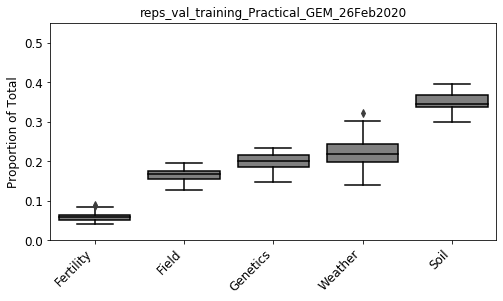

         Weather      Soil     Field  Fertility  Genetics
2014@0  0.191166  0.364053  0.175608   0.084398  0.184775
2014@1  0.255003  0.338945  0.151521   0.060346  0.194185
2014@2  0.207625  0.379654  0.158833   0.059422  0.194467
2014@3  0.253622  0.318570  0.151504   0.064425  0.211880
2014@4  0.213496  0.335120  0.153700   0.083051  0.214632
2014@5  0.245616  0.336546  0.153510   0.064528  0.199800
2014@6  0.140020  0.389867  0.170406   0.087373  0.212334
2014@7  0.212953  0.372023  0.163249   0.051838  0.199937
2014@8  0.168420  0.357806  0.161583   0.088905  0.223285
2014@9  0.233039  0.345565  0.153567   0.067161  0.200668
2015@0  0.230008  0.344579  0.165322   0.063983  0.196109
2015@1  0.172409  0.365089  0.171185   0.068962  0.222356
2015@2  0.229806  0.341115  0.147775   0.075580  0.205725
2015@3  0.300898  0.298674  0.128260   0.064614  0.207554
2015@4  0.264961  0.314767  0.154848   0.060012  0.205413
2015@5  0.245287  0.312378  0.148135   0.067837  0.226362
2015@6  0.2133

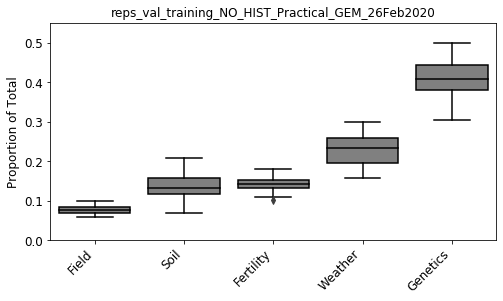

         Weather      Soil     Field  Fertility  Genetics
2014@0  0.281431  0.185981  0.086666   0.138697  0.307225
2014@1  0.205513  0.153214  0.098443   0.151809  0.391020
2014@2  0.179993  0.141899  0.096902   0.154574  0.426632
2014@3  0.202844  0.185334  0.098536   0.130731  0.382555
2014@4  0.241637  0.148963  0.095799   0.133663  0.379938
2014@5  0.245322  0.152460  0.084472   0.136237  0.381509
2014@6  0.280443  0.172202  0.084451   0.133003  0.329901
2014@7  0.254585  0.191446  0.079673   0.114408  0.359888
2014@8  0.230092  0.121297  0.093555   0.163980  0.391076
2014@9  0.298736  0.176451  0.089435   0.110917  0.324461
2015@0  0.178181  0.161853  0.075202   0.152298  0.432466
2015@1  0.291005  0.199602  0.065729   0.102697  0.340967
2015@2  0.197833  0.157755  0.074968   0.150546  0.418898
2015@3  0.183959  0.138773  0.078514   0.142625  0.456129
2015@4  0.232784  0.159072  0.073833   0.132266  0.402045
2015@5  0.279640  0.151661  0.064795   0.129356  0.374548
2015@6  0.2928

In [16]:
#####Box plots by major catigories#####

prefix="reps_val_training_"
train_test_sets="Train_val_test_sets_Practical_GEM_26Feb2020.json"
method=prefix+train_test_sets[20:-5]

weath_train_splits, cons_train_splits, pcs_train_splits = import_sal_data_by_method(method)
sal_weath, sal_soil, sal_field, sal_fert, sal_pcs = divide_and_label_data_keeping_splits(weath_train_splits, cons_train_splits, pcs_train_splits)
print(sal_weath.shape, sal_soil.shape, sal_field.shape, sal_fert.shape, sal_pcs.shape)

main_cats_splts = sum_and_devide_for_for_perct(sal_weath, sal_soil, sal_field, sal_fert, sal_pcs)
create_box_plot(main_cats_splts, figsize=(8,4))
print(main_cats_splts)

prefix="reps_val_training_"
train_test_sets="Train_val_test_sets_NO_HIST_Practical_GEM_26Feb2020.json"
method=prefix+train_test_sets[20:-5]

weath_train_splits, cons_train_splits, pcs_train_splits = import_sal_data_by_method(method)
sal_weath, sal_soil, sal_field, sal_fert, sal_pcs = divide_and_label_data_keeping_splits(weath_train_splits, cons_train_splits, pcs_train_splits)
print(sal_weath.shape, sal_soil.shape, sal_field.shape, sal_fert.shape, sal_pcs.shape)

main_cats_splts = sum_and_devide_for_for_perct(sal_weath, sal_soil, sal_field, sal_fert, sal_pcs)
create_box_plot(main_cats_splts, figsize=(8,4))
print(main_cats_splts)

(1200, 1163) (1200, 47) (1200, 58)
(1200, 1163) (1200, 47) (1200, 58)
(40, 1160) (40, 44) (40, 55)
(1200, 1163) (1200, 47) (1200, 58)
(1200, 1163) (1200, 47) (1200, 58)
(40, 1160) (40, 44) (40, 55)


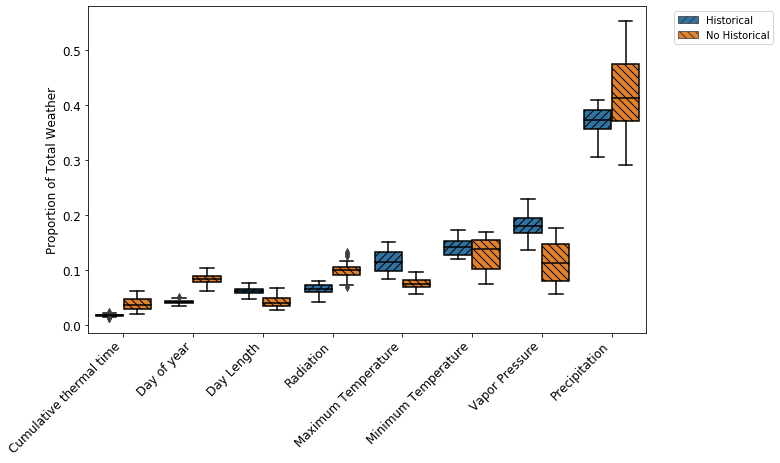

In [17]:
#####create combined weather box plots#####

prefix="reps_val_training_"
train_test_sets="Train_val_test_sets_Practical_GEM_26Feb2020.json"
method=prefix+train_test_sets[20:-5]

weath_train_splits, cons_train_splits, pcs_train_splits = import_sal_data_by_method(method)
sal_weath, sal_soil, sal_field, sal_fert, sal_pcs = divide_and_label_data_keeping_splits(weath_train_splits, cons_train_splits, pcs_train_splits)
#print(sal_weath.shape, sal_soil.shape, sal_field.shape, sal_fert.shape, sal_pcs.shape)

prefix="reps_val_training_"
train_test_sets="Train_val_test_sets_NO_HIST_Practical_GEM_26Feb2020.json"
method=prefix+train_test_sets[20:-5]

weath_train_splits, cons_train_splits, pcs_train_splits = import_sal_data_by_method(method)
sal_weath_NO_hist, sal_soil, sal_field, sal_fert, sal_pcs = divide_and_label_data_keeping_splits(weath_train_splits, cons_train_splits, pcs_train_splits)
#print(sal_weath.shape, sal_soil.shape, sal_field.shape, sal_fert.shape, sal_pcs.shape)

#get percentage for each
sal_weath_pct = convert_to_percentage(sal_weath)
sal_weath_NO_hist_pct = convert_to_percentage(sal_weath_NO_hist)

sal_weath_pct = sal_weath_pct.stack().reset_index()
sal_weath_pct["Hist"]="Historical"

sal_weath_NO_hist_pct = sal_weath_NO_hist_pct.stack().reset_index()
sal_weath_NO_hist_pct["Hist"]="No Historical"

col_order = sal_weath.mean().sort_values().index
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(ax=ax, x="index", y=0, hue="Hist", order=col_order, data= pd.concat([sal_weath_pct, sal_weath_NO_hist_pct]))
ax.set_ylabel("Proportion of Total Weather", fontsize=12, color="black")
ax.set_xlabel("")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
    label.set_color("black")
num_cols = len(col_order) #number of labels across the bottm
hatches = itertools.cycle(['///', '\\\\\\']) #, '---', '|||', '////', '*', 'o', 'O', '.', '+']) # patterns to use
for i,box in enumerate(ax.artists):
    hatch = next(hatches)
    #print(i, i % 2, hatch)
    box.set_hatch(hatch)
for i, bar in enumerate(ax.patches):  #go through each bar and add appropriate patch
    hatch = next(hatches)
    bar.set_hatch(hatch)
ax.set(facecolor = "white")
ax.legend(bbox_to_anchor=(1.04, 1))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_space))
plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.show()

In [18]:
sal_weath_pct.pivot_table(index=["index"])

0
index                            
Cumulative thermal time  0.018681
Day Length               0.062156
Day of year              0.042041
Maximum Temperature      0.115690
Minimum Temperature      0.142690
Precipitation            0.371109
Radiation                0.065510
Vapor Pressure           0.182122

In [19]:
sal_weath_NO_hist_pct.pivot_table(index=["index"])

0
index                            
Cumulative thermal time  0.039197
Day Length               0.042934
Day of year              0.083588
Maximum Temperature      0.075007
Minimum Temperature      0.128252
Precipitation            0.416486
Radiation                0.100013
Vapor Pressure           0.114523

In [20]:
def prop_of_total_plot(avg_sum_large_cats, title, figsize=(8,2),
                       error_kw={"elinewidth":2, "capsize":10, "capthick":1.5}, fmt='%.1f'):
    #sns.set(font_scale=3)
    #create plot as proportion of total.
    cat_mean_percnt = (avg_sum_large_cats/avg_sum_large_cats.sum()["mean"])
    cat_mean_percnt = cat_mean_percnt.sort_values("mean")
    #ax = cat_mean_percnt.plot.bar(y="mean", yerr="stdErr", figsize=(30,5), error_kw={"elinewidth":5, "capsize":30, "capthick":5},
    #                              legend=False)#, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])
    ax = cat_mean_percnt.plot.bar(y="mean", yerr="stdErr", 
                                  error_kw=error_kw,
                                  legend=False, edgecolor='black',
                                  color="gray", figsize=figsize)
    ax.set_ylabel("Proportion of Total")
    ax.set_xlabel("")
    ax.set_title(title)
    ax.set(facecolor = "white")
    #ax.grid(color="lightgray")
    ax.yaxis.set_major_formatter(FormatStrFormatter(fmt))
    plt.show()
    #print(cat_mean_percnt)
    return cat_mean_percnt

(1200, 1163) (1200, 47) (1200, 58)
(1200, 1163) (1200, 47) (1200, 58)
(40, 1160) (40, 44) (40, 55)


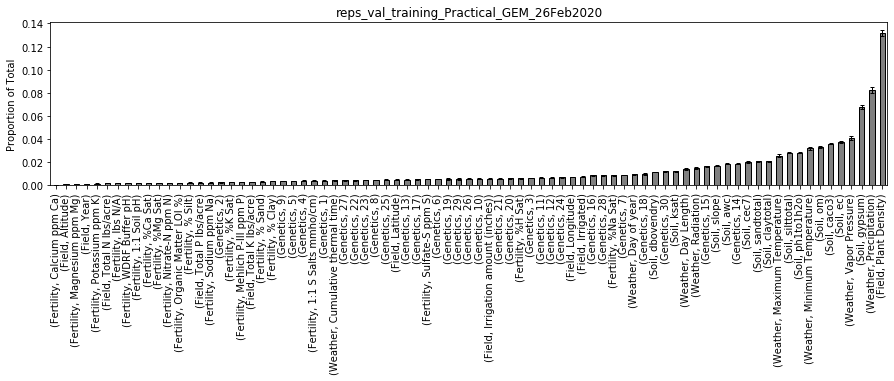

mean       std    stdErr
(Fertility, Calcium ppm Ca)          0.000499  0.000071  0.000011
(Field, Altitude)                    0.000959  0.000161  0.000025
(Fertility, Magnesium ppm Mg)        0.001024  0.000198  0.000031
(Field, Year)                        0.001353  0.000151  0.000024
(Fertility, Potassium ppm K)         0.001543  0.000193  0.000031
(Field, Total N lbs/acre)            0.001673  0.000339  0.000054
(Fertility, lbs N/A)                 0.001962  0.000677  0.000107
(Fertility, WDRF Buffer pH)          0.001997  0.000485  0.000077
(Fertility, 1:1 Soil pH)             0.002001  0.000437  0.000069
(Fertility, %Ca Sat)                 0.002104  0.000565  0.000089
(Fertility, %Mg Sat)                 0.002128  0.000599  0.000095
(Fertility, Nitrate-N ppm N)         0.002307  0.000607  0.000096
(Fertility, Organic Matter LOI %)    0.002316  0.000616  0.000097
(Fertility, % Silt)                  0.002318  0.000706  0.000112
(Field, Total P lbs/acre)            0.002383  0.000643  0.000102
(Fertility, Sodium ppm Na)           0.002419  0.000484  0.000077
(Genetics, 2)                        0.002553  0.001087  0.000172
(Fertility, %K Sat)                  0.002698  0.000778  0.000123
(Fertility, Mehlich P-III ppm P)     0.002935  0.001092  0.000173
(Field, Total K lbs/acre)            0.002986  0.000954  0.000151
(Fertility, % Sand)                  0.003221  0.001072  0.000170
(Fertility, % Clay)                  0.003711  0.001059  0.000167
(Genetics, 9)                        0.003844  0.001610  0.000255
(Genetics, 5)                        0.003860  0.001506  0.000238
(Genetics, 4)                        0.003914  0.001759  0.000278
(Fertility, 1:1 S Salts mmho/cm)     0.004007  0.002171  0.000343
(Genetics, 1)                        0.004079  0.002359  0.000373
(Weather, Cumulative thermal time)   0.004179  0.001027  0.000162
(Genetics, 27)                       0.004377  0.002496  0.000395
(Genetics, 22)                       0.004437  0.002080  0.000329
(Genetics, 23)                       0.004553  0.001836  0.000290
(Genetics, 8)                        0.004589  0.002492  0.000394
(Genetics, 25)                       0.004753  0.002216  0.000350
(Field, Latitude)                    0.004982  0.000775  0.000123
(Genetics, 13)                       0.004985  0.002515  0.000398
(Genetics, 17)                       0.005298  0.002208  0.000349
(Fertility, Sulfate-S ppm S)         0.005419  0.001348  0.000213
(Genetics, 6)                        0.005466  0.002505  0.000396
(Genetics, 19)                       0.005471  0.003055  0.000483
(Genetics, 29)                       0.005494  0.004074  0.000644
(Genetics, 26)                       0.005607  0.002808  0.000444
(Genetics, 10)                       0.005628  0.002198  0.000347
(Field, Irrigation amount (inches))  0.005673  0.002273  0.000359
(Genetics, 21)                       0.005786  0.002296  0.000363
(Genetics, 20)                       0.005956  0.002159  0.000341
(Fertility, %H Sat)                  0.006120  0.001531  0.000242
(Genetics, 3)                        0.006162  0.001626  0.000257
(Genetics, 11)                       0.006389  0.002787  0.000441
(Genetics, 12)                       0.006586  0.003167  0.000501
(Genetics, 24)                       0.006943  0.004035  0.000638
(Field, Longitude)                   0.007082  0.001005  0.000159
(Field, Irrigated)                   0.007453  0.002178  0.000344
(Genetics, 16)                       0.008527  0.002076  0.000328
(Genetics, 28)                       0.008565  0.002692  0.000426
(Fertility, %Na Sat)                 0.008728  0.003141  0.000497
(Genetics, 7)                        0.008857  0.002357  0.000373
(Weather, Day of year)               0.009413  0.002308  0.000365
(Genetics, 18)                       0.009692  0.003688  0.000583
(Soil, dbovendry)                    0.011463  0.001526  0.000241
(Genetics, 30)                       0.011952  0.004109  0.000650
(Soil, ksat)   

In [21]:
####combined bar plots of for all internal categories

prefix="reps_val_training_"
train_test_sets="Train_val_test_sets_Practical_GEM_26Feb2020.json"
method=prefix+train_test_sets[20:-5]

weath_train_splits, cons_train_splits, pcs_train_splits = import_sal_data_by_method(method)
sal_weath, sal_soil, sal_field, sal_fert, sal_pcs = divide_and_label_data_keeping_splits(weath_train_splits, cons_train_splits, pcs_train_splits)
sal_weath.columns.name="level_1"
#print(sal_weath.shape, sal_soil.shape, sal_field.shape, sal_fert.shape, sal_pcs.shape)
#combine sal_soil across depths
sal_soil.columns = sal_soil.columns.str.split("_",expand=True)
sal_soil = sal_soil.unstack().reset_index().pivot_table(index=["level_1"], columns="Soil", values=0, aggfunc=sum).T

all_factors_mean = []
all_factors_std = []
for df in [sal_weath, sal_soil, sal_field, sal_fert, sal_pcs]:
    all_factors_mean.append(pd.DataFrame(df.mean(), columns=[df.index.name]).unstack().reset_index())
    all_factors_std.append(pd.DataFrame(df.std(), columns=[df.index.name]).unstack().reset_index())
all_factors_mean = pd.concat(all_factors_mean)
all_factors_mean.columns = ["broad_cat", "specific_cat","mean"]
all_factors_mean.index = all_factors_mean[["broad_cat","specific_cat"]]

all_factors_std = pd.concat(all_factors_std)
all_factors_std.columns = ["broad_cat", "specific_cat","std"]
all_factors_std.index = all_factors_std[["broad_cat","specific_cat"]]
all_factors_mean["std"] = all_factors_std["std"]
all_factors_mean["stdErr"] = all_factors_mean["std"]/np.sqrt(len(sal_weath))

prop_of_total_plot(all_factors_mean[["mean","std","stdErr"]], method,
                                      figsize=(15,3), error_kw={"elinewidth":1, "capsize":2, "capthick":1}, fmt='%.2f')

(1200, 1163) (1200, 47) (1200, 58)
(1200, 1163) (1200, 47) (1200, 58)
(40, 1160) (40, 44) (40, 55)


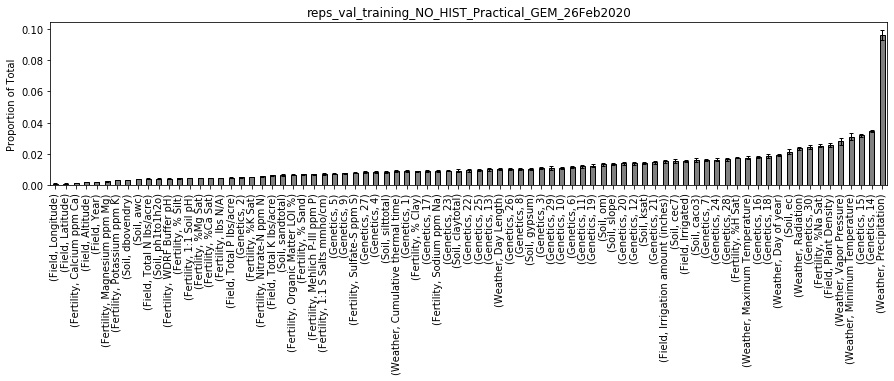

mean       std    stdErr
(Field, Longitude)                   0.001091  0.000400  0.000063
(Field, Latitude)                    0.001120  0.000317  0.000050
(Fertility, Calcium ppm Ca)          0.001346  0.000170  0.000027
(Field, Altitude)                    0.001976  0.000411  0.000065
(Field, Year)                        0.002377  0.000265  0.000042
(Fertility, Magnesium ppm Mg)        0.002461  0.000450  0.000071
(Fertility, Potassium ppm K)         0.003249  0.000490  0.000077
(Soil, dbovendry)                    0.003369  0.001106  0.000175
(Soil, awc)                          0.004020  0.001383  0.000219
(Field, Total N lbs/acre)            0.004268  0.000734  0.000116
(Soil, ph1to1h2o)                    0.004271  0.001255  0.000198
(Fertility, WDRF Buffer pH)          0.004317  0.000884  0.000140
(Fertility, % Silt)                  0.004483  0.000951  0.000150
(Fertility, 1:1 Soil pH)             0.004486  0.000875  0.000138
(Fertility, %Mg Sat)                 0.004568  0.001061  0.000168
(Fertility, %Ca Sat)                 0.004616  0.001093  0.000173
(Fertility, lbs N/A)                 0.004772  0.001207  0.000191
(Field, Total P lbs/acre)            0.004798  0.001210  0.000191
(Genetics, 2)                        0.005090  0.002124  0.000336
(Fertility, %K Sat)                  0.005288  0.001223  0.000193
(Fertility, Nitrate-N ppm N)         0.005692  0.001709  0.000270
(Field, Total K lbs/acre)            0.006461  0.002067  0.000327
(Soil, sandtotal)                    0.006666  0.002592  0.000410
(Fertility, Organic Matter LOI %)    0.006737  0.001424  0.000225
(Fertility, % Sand)                  0.006910  0.001827  0.000289
(Fertility, Mehlich P-III ppm P)     0.007008  0.002173  0.000344
(Fertility, 1:1 S Salts mmho/cm)     0.007129  0.003038  0.000480
(Genetics, 5)                        0.007334  0.002643  0.000418
(Genetics, 9)                        0.007638  0.003056  0.000483
(Fertility, Sulfate-S ppm S)         0.008067  0.002064  0.000326
(Genetics, 27)                       0.008394  0.004365  0.000690
(Genetics, 4)                        0.008563  0.003733  0.000590
(Soil, silttotal)                    0.008763  0.004195  0.000663
(Weather, Cumulative thermal time)   0.008969  0.003087  0.000488
(Genetics, 1)                        0.008982  0.004138  0.000654
(Fertility, % Clay)                  0.008983  0.001844  0.000291
(Genetics, 17)                       0.008990  0.004546  0.000719
(Fertility, Sodium ppm Na)           0.009000  0.003394  0.000537
(Genetics, 23)                       0.009350  0.003174  0.000502
(Soil, claytotal)                    0.009406  0.004777  0.000755
(Genetics, 22)                       0.009463  0.004524  0.000715
(Genetics, 25)                       0.009668  0.004035  0.000638
(Genetics, 13)                       0.010141  0.004949  0.000782
(Weather, Day Length)                0.010175  0.003780  0.000598
(Genetics, 26)                       0.010277  0.004934  0.000780
(Genetics, 8)                        0.010345  0.005023  0.000794
(Soil, gypsum)                       0.010530  0.003998  0.000632
(Genetics, 3)                        0.010944  0.003051  0.000482
(Genetics, 29)                       0.011012  0.007000  0.001107
(Genetics, 10)                       0.011247  0.004069  0.000643
(Genetics, 6)                        0.011730  0.005336  0.000844
(Genetics, 11)                       0.012120  0.006021  0.000952
(Genetics, 19)                       0.012474  0.006354  0.001005
(Soil, om)                           0.013413  0.005345  0.000845
(Soil, slope)                        0.013432  0.003301  0.000522
(Genetics, 20)                       0.013933  0.004624  0.000731
(Genetics, 12)                       0.013992  0.007009  0.001108
(Soil, ksat)                         0.014189  0.004690  0.000741
(Genetics, 21)                       0.014567  0.005447  0.000861
(Field, Irrigation amount (inches))  0.015219  0.005519  0.000873
(Soil, cec7)   

In [23]:
prefix="reps_val_training_"
train_test_sets="Train_val_test_sets_NO_HIST_Practical_GEM_26Feb2020.json"
method=prefix+train_test_sets[20:-5]

weath_train_splits, cons_train_splits, pcs_train_splits = import_sal_data_by_method(method)
sal_weath, sal_soil, sal_field, sal_fert, sal_pcs = divide_and_label_data_keeping_splits(weath_train_splits, cons_train_splits, pcs_train_splits)
sal_weath.columns.name="level_1"
#print(sal_weath.shape, sal_soil.shape, sal_field.shape, sal_fert.shape, sal_pcs.shape)
#combine sal_soil across depths
sal_soil.columns = sal_soil.columns.str.split("_",expand=True)
sal_soil = sal_soil.unstack().reset_index().pivot_table(index=["level_1"], columns="Soil", values=0, aggfunc=sum).T

all_factors_mean = []
all_factors_std = []
for df in [sal_weath, sal_soil, sal_field, sal_fert, sal_pcs]:
    all_factors_mean.append(pd.DataFrame(df.mean(), columns=[df.index.name]).unstack().reset_index())
    all_factors_std.append(pd.DataFrame(df.std(), columns=[df.index.name]).unstack().reset_index())
all_factors_mean = pd.concat(all_factors_mean)
all_factors_mean.columns = ["broad_cat", "specific_cat","mean"]
all_factors_mean.index = all_factors_mean[["broad_cat","specific_cat"]]

all_factors_std = pd.concat(all_factors_std)
all_factors_std.columns = ["broad_cat", "specific_cat","std"]
all_factors_std.index = all_factors_std[["broad_cat","specific_cat"]]
all_factors_mean["std"] = all_factors_std["std"]
all_factors_mean["stdErr"] = all_factors_mean["std"]/np.sqrt(len(sal_weath))

prop_of_total_plot(all_factors_mean[["mean","std","stdErr"]], method,
                                      figsize=(15,3), error_kw={"elinewidth":1, "capsize":2, "capthick":1}, fmt='%.2f')

In [24]:
def get_summarize_data_into_specific_cats(method):
    weath_train_splits, cons_train_splits, pcs_train_splits = import_sal_data_by_method(method)
    sal_weath, sal_soil, sal_field, sal_fert, sal_pcs = divide_and_label_data_keeping_splits(weath_train_splits, cons_train_splits, pcs_train_splits)
    sal_weath.columns.name="level_1"
    #print(sal_weath.shape, sal_soil.shape, sal_field.shape, sal_fert.shape, sal_pcs.shape)
    #combine sal_soil across depths
    sal_soil.columns = sal_soil.columns.str.split("_",expand=True)
    sal_soil = sal_soil.unstack().reset_index().pivot_table(index=["level_1"], columns="Soil", values=0, aggfunc=sum).T

    all_factors_mean = []
    all_factors_std = []
    for df in [sal_weath, sal_soil, sal_field, sal_fert, sal_pcs]:
        all_factors_mean.append(pd.DataFrame(df.mean(), columns=[df.index.name]).unstack().reset_index())
        all_factors_std.append(pd.DataFrame(df.std(), columns=[df.index.name]).unstack().reset_index())
    all_factors_mean = pd.concat(all_factors_mean)
    all_factors_mean.columns = ["broad_cat", "specific_cat","mean"]
    all_factors_mean.index = all_factors_mean[["broad_cat","specific_cat"]]

    all_factors_std = pd.concat(all_factors_std)
    all_factors_std.columns = ["broad_cat", "specific_cat","std"]
    all_factors_std.index = all_factors_std[["broad_cat","specific_cat"]]
    all_factors_mean["std"] = all_factors_std["std"]
    all_factors_mean["stdErr"] = all_factors_mean["std"]/np.sqrt(len(sal_weath))

    all_factors_mean.index = pd.MultiIndex.from_tuples(all_factors_mean.index.tolist(), names=["Broad_cat","Specific_cat"])
    all_factors_mean = all_factors_mean[["mean","std","stdErr"]]
    return all_factors_mean

In [28]:
def barplot_sng_cat(all_fact_mean, cat, tick_space, figsize=(10,4)):
    means = all_fact_mean.loc[cat].reset_index().pivot(index="scenario", columns="Specific_cat", values="mean").T.copy()
    means = means.sort_values(["GEM Practical"]).T
    std_Err = all_fact_mean.loc[cat].reset_index().pivot(index="scenario", columns="Specific_cat", values="stdErr").T.copy().T
    means["sum"] = means.sum(axis=1)
    for col in means.columns[:-1]:
        means[col] = means[col]/means["sum"]
        std_Err[col] = std_Err[col]/means["sum"]
        #std[col] = std[col]/means["sum"]
    means = means.drop(columns=["sum"])

    ax2 = means.T.plot(kind="bar", yerr=std_Err.T, figsize=figsize, edgecolor="white")
    num_cols = len(means.T.index) #number of labels across the bottm
    hatches = itertools.cycle(['///', '\\\\\\', '---', '|||', '////', '*', 'o', 'O', '.', '+']) # patterns to use
    for i, bar in enumerate(ax2.patches):  #go through each bar and add appropriate patch
        #print(i, bar, i % num_cols)
        if i % num_cols==0:  #if remainder is zero then we are on a new series (G, E, etc. in this case)
            hatch = next(hatches)
        bar.set_hatch(hatch)

    ax2.set_xlabel("")
    ax2.set_ylabel("Proportion of Total")
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(tick_space))
    ax2.legend(loc='upper left')#bbox_to_anchor=(0.04, 1))
    ax2.set(facecolor = "white")
    #ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    #ax2.grid(color="lightgray", axis='y')
    plt.show()
    print(means.T)

(1470, 1163) (1470, 47) (1470, 58)
(1470, 1163) (1470, 47) (1470, 58)
(49, 1160) (49, 44) (49, 55)
(1200, 1163) (1200, 47) (1200, 58)
(1200, 1163) (1200, 47) (1200, 58)
(40, 1160) (40, 44) (40, 55)
(2190, 1163) (2190, 47) (2190, 58)
(2190, 1163) (2190, 47) (2190, 58)
(73, 1160) (73, 44) (73, 55)
(1500, 1163) (1500, 47) (1500, 58)
(1500, 1163) (1500, 47) (1500, 58)
(50, 1160) (50, 44) (50, 55)


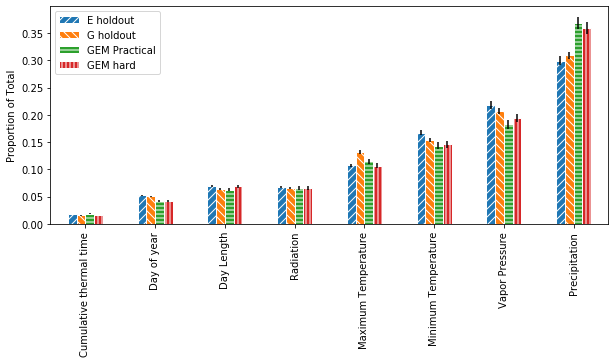

scenario                 E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                                          
Cumulative thermal time   0.018208   0.015661       0.018691  0.016480
Day of year               0.052272   0.050784       0.042104  0.041663
Day Length                0.069576   0.064425       0.062573  0.068971
Radiation                 0.067683   0.065961       0.066272  0.066105
Maximum Temperature       0.107289   0.132673       0.114824  0.106810
Minimum Temperature       0.167316   0.154369       0.143579  0.145964
Vapor Pressure            0.217971   0.207108       0.183145  0.194464
Precipitation             0.299684   0.309020       0.368811  0.359543


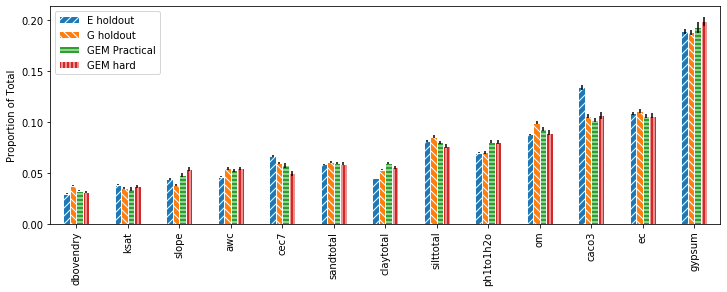

scenario      E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                               
dbovendry      0.029663   0.037419       0.032634  0.031264
ksat           0.038582   0.035096       0.034217  0.036773
slope          0.043773   0.038452       0.048053  0.053851
awc            0.046319   0.054493       0.052692  0.054786
cec7           0.066520   0.059898       0.057374  0.049888
sandtotal      0.058585   0.060927       0.059362  0.059126
claytotal      0.045049   0.053381       0.059639  0.055500
silttotal      0.081480   0.085857       0.080176  0.076490
ph1to1h2o      0.070074   0.070273       0.080775  0.080459
om             0.087855   0.099549       0.093693  0.089689
caco3          0.134173   0.105582       0.102504  0.106572
ec             0.108605   0.110829       0.105793  0.106454
gypsum         0.189322   0.188243       0.193088  0.199148


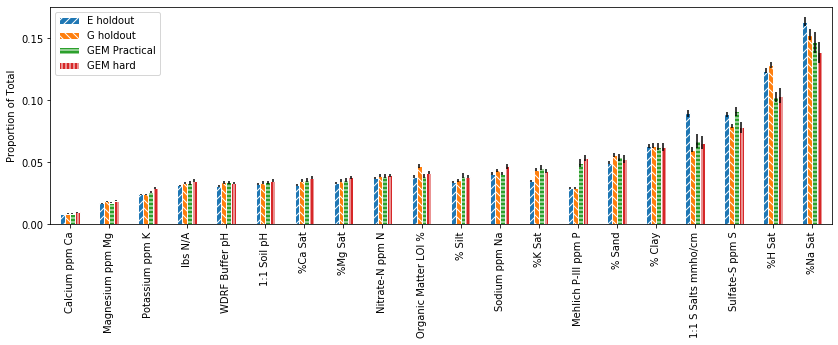

scenario              E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                                       
Calcium ppm Ca         0.008147   0.008409       0.008395  0.009551
Magnesium ppm Mg       0.016711   0.018382       0.017228  0.019032
Potassium ppm K        0.024235   0.024096       0.025956  0.029314
lbs N/A                0.031279   0.033202       0.032998  0.035010
WDRF Buffer pH         0.030523   0.033664       0.033589  0.033405
1:1 Soil pH            0.032244   0.033356       0.033662  0.034807
%Ca Sat                0.031608   0.035145       0.035381  0.037528
%Mg Sat                0.032963   0.035149       0.035784  0.037699
Nitrate-N ppm N        0.036937   0.039037       0.038799  0.039464
Organic Matter LOI %   0.038426   0.047008       0.038957  0.041511
% Silt                 0.033746   0.035416       0.038987  0.038326
Sodium ppm Na          0.040732   0.043551       0.040693  0.046632
%K Sat                 0.034675   0.043849      

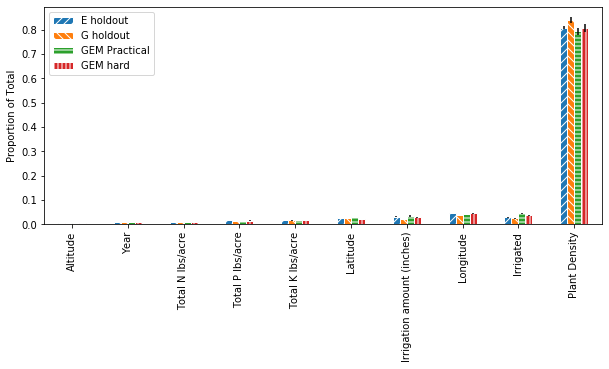

scenario                    E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                                             
Altitude                     0.006671   0.005555       0.005763  0.006793
Year                         0.008646   0.009597       0.008131  0.009250
Total N lbs/acre             0.011027   0.008490       0.010053  0.010656
Total P lbs/acre             0.016081   0.012095       0.014320  0.015420
Total K lbs/acre             0.018083   0.015740       0.017944  0.018327
Latitude                     0.027414   0.025289       0.029938  0.021898
Irrigation amount (inches)   0.031088   0.022408       0.034087  0.029272
Longitude                    0.045172   0.037936       0.042554  0.044824
Irrigated                    0.028406   0.023883       0.044784  0.036535
Plant Density                0.807412   0.839007       0.792425  0.807026


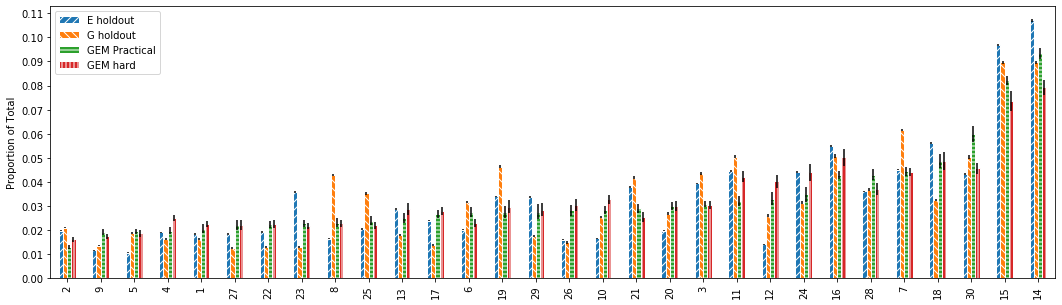

scenario      E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                               
2              0.019657   0.020936       0.012808  0.016039
9              0.011506   0.013488       0.019287  0.017268
5              0.010443   0.018651       0.019369  0.018627
4              0.019011   0.016181       0.019640  0.024800
1              0.018283   0.016220       0.020465  0.022535
27             0.018289   0.012464       0.021960  0.021953
22             0.019182   0.012927       0.022262  0.022529
23             0.035630   0.013050       0.022843  0.021502
8              0.016287   0.042910       0.023027  0.022726
25             0.020319   0.035277       0.023848  0.021891
13             0.028706   0.017796       0.025013  0.028589
17             0.023900   0.013847       0.026580  0.027816
6              0.020129   0.031599       0.027423  0.022874
19             0.033925   0.046224       0.027450  0.029722
29             0.033657   0.017526      

In [29]:
#Import data from several scenarios, get average and std, concatinat, plot

#####with historical data#####

methods_list = ["GEM_reps_val_training_13_Dec2019", 
                "reps_val_training_Practical_GEM_26Feb2020",
                "reps_val_training_E_dwnSample293_24Apr2020",
                "reps_val_training_G_dwnSample12_23Apr2020"]
all_fact_mean = []
for method in methods_list:
    all_factors_mean = get_summarize_data_into_specific_cats(method)
    all_factors_mean["method"]=method
    all_fact_mean.append(all_factors_mean.copy())
all_fact_mean = pd.concat(all_fact_mean)

#add extra column with testing scenario
all_fact_mean["scenario"] = all_fact_mean["method"].str[-10:]
repl = {'_23Apr2020':"G holdout", '13_Dec2019':"GEM hard", '_26Feb2020':"GEM Practical", '_24Apr2020':"E holdout"}
for key in repl:
    #print(key)
    all_fact_mean["scenario"] = all_fact_mean["scenario"].str.replace(key, repl[key])

#with historical data
barplot_sng_cat(all_fact_mean, cat="Weather", tick_space=0.05, figsize=(10,4))
barplot_sng_cat(all_fact_mean, cat="Soil", tick_space=0.05, figsize=(12,4))
barplot_sng_cat(all_fact_mean, cat="Fertility", tick_space=0.05, figsize=(14,4))
barplot_sng_cat(all_fact_mean, cat="Field", tick_space=0.1, figsize=(10,4))
barplot_sng_cat(all_fact_mean, cat="Genetics", tick_space=0.01, figsize=(18,5))

(1470, 1163) (1470, 47) (1470, 58)
(1470, 1163) (1470, 47) (1470, 58)
(49, 1160) (49, 44) (49, 55)
(1200, 1163) (1200, 47) (1200, 58)
(1200, 1163) (1200, 47) (1200, 58)
(40, 1160) (40, 44) (40, 55)
(2190, 1163) (2190, 47) (2190, 58)
(2190, 1163) (2190, 47) (2190, 58)
(73, 1160) (73, 44) (73, 55)
(1500, 1163) (1500, 47) (1500, 58)
(1500, 1163) (1500, 47) (1500, 58)
(50, 1160) (50, 44) (50, 55)


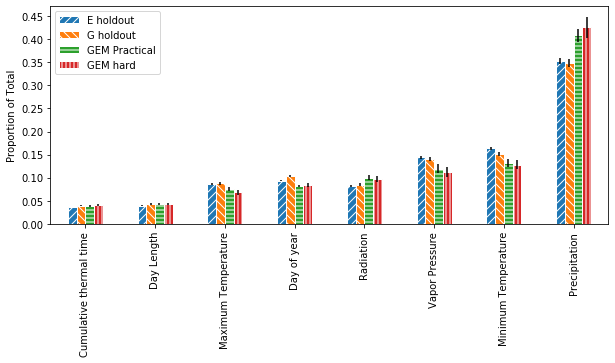

scenario                 E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                                          
Cumulative thermal time   0.036675   0.039449       0.038202  0.040824
Day Length                0.039653   0.043147       0.043335  0.043268
Maximum Temperature       0.086463   0.088529       0.075557  0.068405
Day of year               0.093953   0.103974       0.082168  0.084138
Radiation                 0.081698   0.085189       0.100335  0.097302
Vapor Pressure            0.144594   0.140213       0.119964  0.112172
Minimum Temperature       0.163836   0.150788       0.132357  0.128050
Precipitation             0.353128   0.348712       0.408083  0.425842


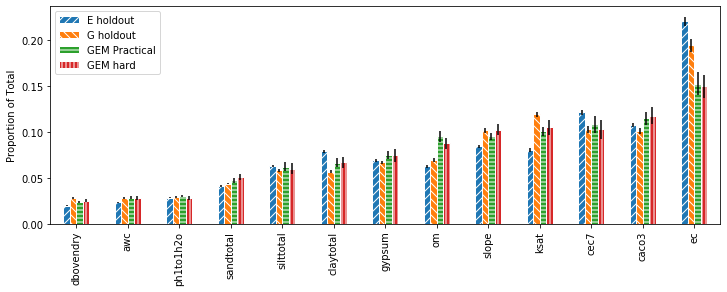

scenario      E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                               
dbovendry      0.019581   0.027938       0.023888  0.025247
awc            0.023528   0.027934       0.028500  0.028334
ph1to1h2o      0.028411   0.029249       0.030281  0.028257
sandtotal      0.040971   0.043738       0.047265  0.051028
silttotal      0.063167   0.058478       0.062134  0.060056
claytotal      0.078818   0.056851       0.066688  0.067266
gypsum         0.069134   0.066965       0.074662  0.074510
om             0.062437   0.069712       0.095105  0.087548
slope          0.084322   0.101846       0.095235  0.102578
ksat           0.080247   0.119137       0.100603  0.104919
cec7           0.121370   0.102763       0.108287  0.103022
caco3          0.107669   0.100994       0.114819  0.117457
ec             0.220343   0.194394       0.152534  0.149778


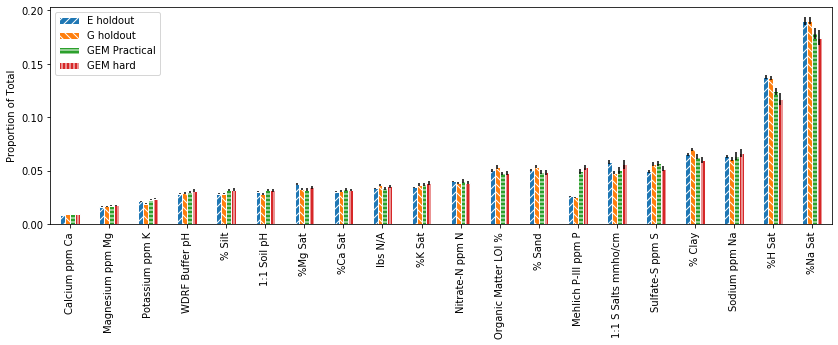

scenario              E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                                       
Calcium ppm Ca         0.008627   0.009069       0.009468  0.009620
Magnesium ppm Mg       0.016303   0.016696       0.017310  0.017537
Potassium ppm K        0.021278   0.019194       0.022853  0.023710
WDRF Buffer pH         0.028526   0.028796       0.030364  0.031247
% Silt                 0.028508   0.028460       0.031529  0.032260
1:1 Soil pH            0.030191   0.028029       0.031551  0.031620
%Mg Sat                0.037449   0.032894       0.032126  0.034468
%Ca Sat                0.030464   0.030838       0.032465  0.031778
lbs N/A                0.033539   0.036617       0.033563  0.035197
%K Sat                 0.034292   0.036949       0.037190  0.038537
Nitrate-N ppm N        0.039828   0.038448       0.040031  0.038791
Organic Matter LOI %   0.050239   0.053581       0.047384  0.047586
% Sand                 0.050720   0.053773      

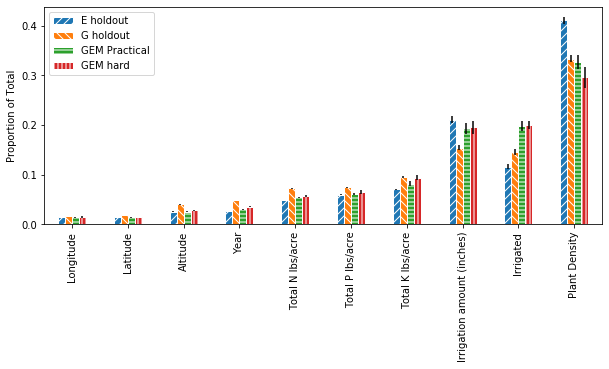

scenario                    E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                                             
Longitude                    0.014704   0.016597       0.013870  0.014691
Latitude                     0.015135   0.018405       0.014242  0.014773
Altitude                     0.025781   0.040215       0.025128  0.027962
Year                         0.027558   0.049350       0.030219  0.035292
Total N lbs/acre             0.048957   0.072565       0.054269  0.056223
Total P lbs/acre             0.059509   0.074342       0.061008  0.064937
Total K lbs/acre             0.070813   0.095321       0.082151  0.094036
Irrigation amount (inches)   0.210598   0.153859       0.193526  0.195291
Irrigated                    0.116168   0.145570       0.198285  0.200312
Plant Density                0.410776   0.333776       0.327300  0.296482


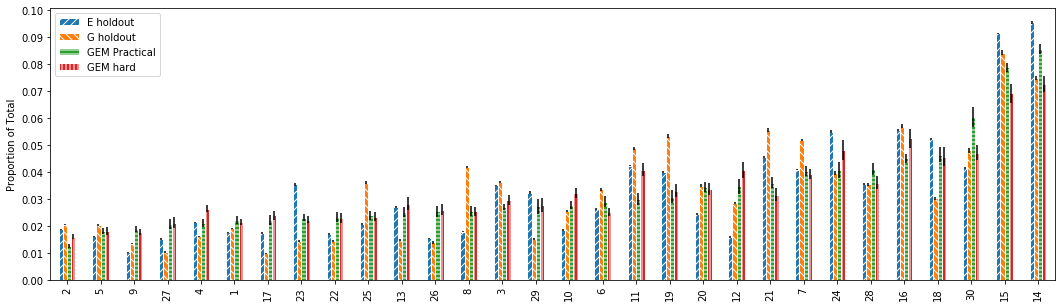

scenario      E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                               
2              0.018880   0.020501       0.012619  0.016126
5              0.016286   0.020407       0.018182  0.018286
9              0.010279   0.013527       0.018936  0.017806
27             0.015293   0.010426       0.020810  0.021205
4              0.021464   0.016219       0.021229  0.026518
1              0.017783   0.019131       0.022268  0.021646
17             0.017398   0.009893       0.022288  0.023992
23             0.035488   0.014489       0.023180  0.022331
22             0.017213   0.014547       0.023462  0.022937
25             0.020866   0.036290       0.023970  0.023556
13             0.027087   0.014984       0.025142  0.028378
26             0.015486   0.013977       0.025478  0.026032
8              0.017926   0.041975       0.025648  0.025419
3              0.035083   0.036302       0.027133  0.029576
29             0.032303   0.015292      

In [30]:
#####withOUT historical data#####

methods_list = ["reps_val_training_NO_HIST_13_Dec2019", 
                "reps_val_training_NO_HIST_Practical_GEM_26Feb2020",
                "reps_val_training_NO_HIST_E_dwnSample293_24Apr2020",
                "reps_val_training_NO_HIST_G_dwnSample12_23Apr2020"]
all_fact_mean = []
for method in methods_list:
    all_factors_mean = get_summarize_data_into_specific_cats(method)
    all_factors_mean["method"]=method
    all_fact_mean.append(all_factors_mean.copy())
all_fact_mean = pd.concat(all_fact_mean)

#add extra column with testing scenario
all_fact_mean["scenario"] = all_fact_mean["method"].str[-10:]
repl = {'_23Apr2020':"G holdout", '13_Dec2019':"GEM hard", '_26Feb2020':"GEM Practical", '_24Apr2020':"E holdout"}
for key in repl:
    #print(key)
    all_fact_mean["scenario"] = all_fact_mean["scenario"].str.replace(key, repl[key])

#without historical data
barplot_sng_cat(all_fact_mean, cat="Weather", tick_space=0.05, figsize=(10,4))
barplot_sng_cat(all_fact_mean, cat="Soil", tick_space=0.05, figsize=(12,4))
barplot_sng_cat(all_fact_mean, cat="Fertility", tick_space=0.05, figsize=(14,4))
barplot_sng_cat(all_fact_mean, cat="Field", tick_space=0.1, figsize=(10,4))
barplot_sng_cat(all_fact_mean, cat="Genetics", tick_space=0.01, figsize=(18,5))

(1470, 1163) (1470, 47) (1470, 58)
(1470, 1163) (1470, 47) (1470, 58)
(49, 1160) (49, 44) (49, 55)
(1200, 1163) (1200, 47) (1200, 58)
(1200, 1163) (1200, 47) (1200, 58)
(40, 1160) (40, 44) (40, 55)
(2190, 1163) (2190, 47) (2190, 58)
(2190, 1163) (2190, 47) (2190, 58)
(73, 1160) (73, 44) (73, 55)
(1500, 1163) (1500, 47) (1500, 58)
(1500, 1163) (1500, 47) (1500, 58)
(50, 1160) (50, 44) (50, 55)


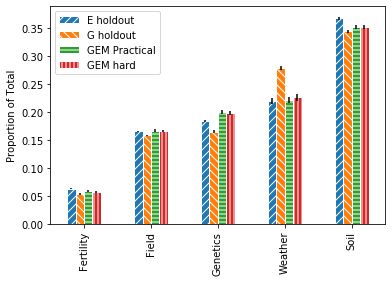

scenario      E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                               
Fertility      0.063073   0.053545       0.059642  0.056838
Field          0.165618   0.158181       0.166738  0.166389
Genetics       0.184030   0.165036       0.200066  0.198009
Weather        0.219776   0.278625       0.222167  0.226412
Soil           0.367503   0.344613       0.351387  0.352352


In [31]:
#summarize by Broad categories
#####with historical data#####

methods_list = ["GEM_reps_val_training_13_Dec2019", 
                "reps_val_training_Practical_GEM_26Feb2020",
                "reps_val_training_E_dwnSample293_24Apr2020",
                "reps_val_training_G_dwnSample12_23Apr2020"]
all_fact_mean = []
for method in methods_list:
    weath_train_splits, cons_train_splits, pcs_train_splits = import_sal_data_by_method(method)
    sal_weath, sal_soil, sal_field, sal_fert, sal_pcs = divide_and_label_data_keeping_splits(weath_train_splits, cons_train_splits, pcs_train_splits)
    #print(sal_weath.shape, sal_soil.shape, sal_field.shape, sal_fert.shape, sal_pcs.shape)
    main_cats_splts = sum_and_devide_for_for_perct(sal_weath, sal_soil, sal_field, sal_fert, sal_pcs)
    main_cats_splts = pd.DataFrame([main_cats_splts.mean(), main_cats_splts.std(), main_cats_splts.std()/np.sqrt(len(main_cats_splts))],
                                   index=["mean","std","stdErr"]).T
    main_cats_splts["method"]=method
    all_fact_mean.append(main_cats_splts.copy())
all_fact_mean = pd.concat(all_fact_mean)

#add extra column with testing scenario
all_fact_mean["scenario"] = all_fact_mean["method"].str[-10:]
repl = {'_23Apr2020':"G holdout", '13_Dec2019':"GEM hard", '_26Feb2020':"GEM Practical", '_24Apr2020':"E holdout"}
for key in repl:
    #print(key)
    all_fact_mean["scenario"] = all_fact_mean["scenario"].str.replace(key, repl[key])
all_fact_mean.index = pd.MultiIndex.from_tuples(list(zip(["all"]*len(all_fact_mean),all_fact_mean.index.tolist())), names=["Broad_cat","Specific_cat"])

barplot_sng_cat(all_fact_mean, cat="all", tick_space=0.05, figsize=(6,4))

(1470, 1163) (1470, 47) (1470, 58)
(1470, 1163) (1470, 47) (1470, 58)
(49, 1160) (49, 44) (49, 55)
(1200, 1163) (1200, 47) (1200, 58)
(1200, 1163) (1200, 47) (1200, 58)
(40, 1160) (40, 44) (40, 55)
(2190, 1163) (2190, 47) (2190, 58)
(2190, 1163) (2190, 47) (2190, 58)
(73, 1160) (73, 44) (73, 55)
(1500, 1163) (1500, 47) (1500, 58)
(1500, 1163) (1500, 47) (1500, 58)
(50, 1160) (50, 44) (50, 55)


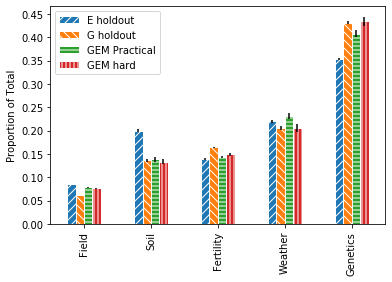

scenario      E holdout  G holdout  GEM Practical  GEM hard
Specific_cat                                               
Field          0.085618   0.062101       0.078245  0.076387
Soil           0.200103   0.136100       0.138393  0.133730
Fertility      0.139689   0.164111       0.143156  0.149474
Weather        0.220409   0.206433       0.232179  0.205884
Genetics       0.354182   0.431255       0.408027  0.434525


In [32]:
#####withOUT historical data#####

methods_list = ["reps_val_training_NO_HIST_13_Dec2019", 
                "reps_val_training_NO_HIST_Practical_GEM_26Feb2020",
                "reps_val_training_NO_HIST_E_dwnSample293_24Apr2020",
                "reps_val_training_NO_HIST_G_dwnSample12_23Apr2020"]
all_fact_mean = []
for method in methods_list:
    weath_train_splits, cons_train_splits, pcs_train_splits = import_sal_data_by_method(method)
    sal_weath, sal_soil, sal_field, sal_fert, sal_pcs = divide_and_label_data_keeping_splits(weath_train_splits, cons_train_splits, pcs_train_splits)
    #print(sal_weath.shape, sal_soil.shape, sal_field.shape, sal_fert.shape, sal_pcs.shape)
    main_cats_splts = sum_and_devide_for_for_perct(sal_weath, sal_soil, sal_field, sal_fert, sal_pcs)
    main_cats_splts = pd.DataFrame([main_cats_splts.mean(), main_cats_splts.std(), main_cats_splts.std()/np.sqrt(len(main_cats_splts))],
                                   index=["mean","std","stdErr"]).T
    main_cats_splts["method"]=method
    all_fact_mean.append(main_cats_splts.copy())
all_fact_mean = pd.concat(all_fact_mean)

#add extra column with testing scenario
all_fact_mean["scenario"] = all_fact_mean["method"].str[-10:]
repl = {'_23Apr2020':"G holdout", '13_Dec2019':"GEM hard", '_26Feb2020':"GEM Practical", '_24Apr2020':"E holdout"}
for key in repl:
    #print(key)
    all_fact_mean["scenario"] = all_fact_mean["scenario"].str.replace(key, repl[key])
all_fact_mean.index = pd.MultiIndex.from_tuples(list(zip(["all"]*len(all_fact_mean),all_fact_mean.index.tolist())), names=["Broad_cat","Specific_cat"])

barplot_sng_cat(all_fact_mean, cat="all", tick_space=0.05, figsize=(6,4))